In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'utkface-new:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F44109%2F78156%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240810%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240810T165910Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D19b505c5425d03b1a7ca30a8548c6b69dde20cd6d7591f2d27cfc8a7e6fe8a7fdc68699875d12d440b112ccb644905c26f9d79c5020ee58ee377de0533bd170472d5fc2ff13e4e4af8cfb1677e945cfcaecd663ad96d761c9682a4a949c2eac0cba5da223a266f57e4878587ca13717bf0c7f40d76a058bf84003b6fb6065c8380a80f222130cb0d478a0c8ad328cea7e0771c7a29190b0a45d59c36bb026a9d4c2b740e8249d978abfb505ba6b8709d402e50c138be6a1a50153b4036d1decaa0079cb9197917d4fd91335ac6abd2327334400d5970df189d7b8b14d4bae88d84a336a9226190da8fe07a3afd3cfc1955b8181d568f0c73e768c358e4270efb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 347342542 bytes downloaded
Downloaded and uncompressed: utkface-new
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [5]:
path = Path("/kaggle/input/utkface-new/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [6]:
print(len(filenames))
print(filenames[:3])

23708
['50_0_0_20170117135739223.jpg.chip.jpg', '12_0_0_20170110225348936.jpg.chip.jpg', '40_1_0_20170117150751092.jpg.chip.jpg']


# Data preprocessing

Data I have downloaded is composed of 23,708 images with age and gender in the Image Name. For Example, 1_0_0_239389.JPG image means that age is 1, gender is 0 (male) and 0 refers to the race (not needed in this task).
So I split the image name on ' _ ' so I can get separated age and gender with image.
Also, I have shuffle all the images

In [7]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [8]:
image_path

['36_0_2_20170104203108125.jpg.chip.jpg',
 '9_0_0_20170110220236260.jpg.chip.jpg',
 '25_0_0_20170117190329641.jpg.chip.jpg',
 '42_0_3_20170119204239438.jpg.chip.jpg',
 '26_1_1_20170116171823756.jpg.chip.jpg',
 '60_0_3_20170119201822925.jpg.chip.jpg',
 '31_1_1_20170114031659379.jpg.chip.jpg',
 '25_1_0_20170117151946851.jpg.chip.jpg',
 '56_0_1_20170113151815760.jpg.chip.jpg',
 '40_0_0_20170117191037435.jpg.chip.jpg',
 '18_0_2_20161219205328564.jpg.chip.jpg',
 '38_1_0_20170104202430130.jpg.chip.jpg',
 '10_0_1_20170116225209209.jpg.chip.jpg',
 '53_0_0_20170104212139332.jpg.chip.jpg',
 '26_1_3_20170104215629245.jpg.chip.jpg',
 '26_1_0_20170117201924879.jpg.chip.jpg',
 '59_0_0_20170119211444609.jpg.chip.jpg',
 '18_1_2_20170102234919571.jpg.chip.jpg',
 '29_1_2_20170116220847352.jpg.chip.jpg',
 '26_0_3_20170119184204318.jpg.chip.jpg',
 '45_0_3_20170119201952141.jpg.chip.jpg',
 '42_0_4_20170117185614642.jpg.chip.jpg',
 '54_0_0_20170120223256415.jpg.chip.jpg',
 '53_0_3_20170119205827904.jpg.chip

# From Unstructured data to Structured data

In [9]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

In [10]:
df.head()

,image,age,gender
0,36_0_2_20170104203108125.jpg.chip.jpg,36,0
1,9_0_0_20170110220236260.jpg.chip.jpg,9,0
2,25_0_0_20170117190329641.jpg.chip.jpg,25,0
3,42_0_3_20170119204239438.jpg.chip.jpg,42,0
4,26_1_1_20170116171823756.jpg.chip.jpg,26,1


In [11]:
gender_dict = {0:"Male",1:"Female"}

In [12]:
df = df.astype({'age':'float32', 'gender': 'int32'})

In [13]:
print(df.dtypes)

image      object
age       float32
gender      int32
dtype: object


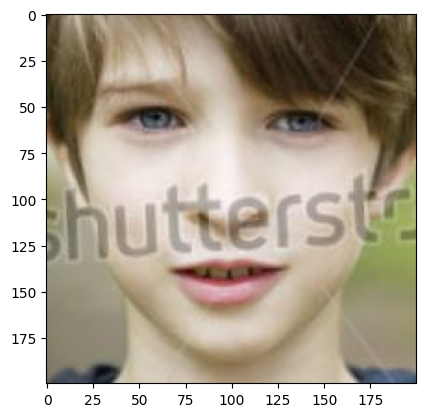

In [16]:
img = Image.open("/kaggle/input/utkface-new/UTKFace/"+df.image[1])
plt.imshow(img)

<ipython-input-17-36725a16e635>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age)


<Axes: xlabel='age', ylabel='Density'>

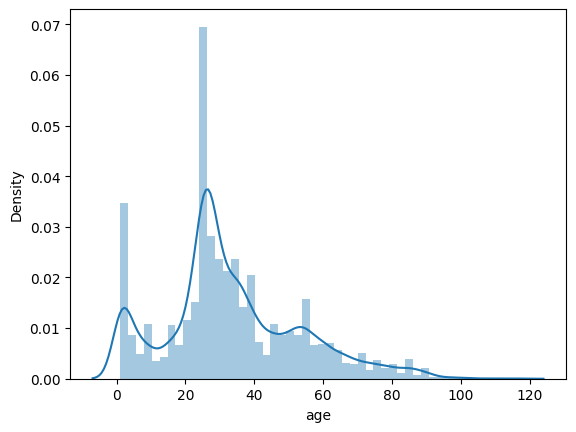

In [17]:
sns.distplot(df.age)

# Plotting Images

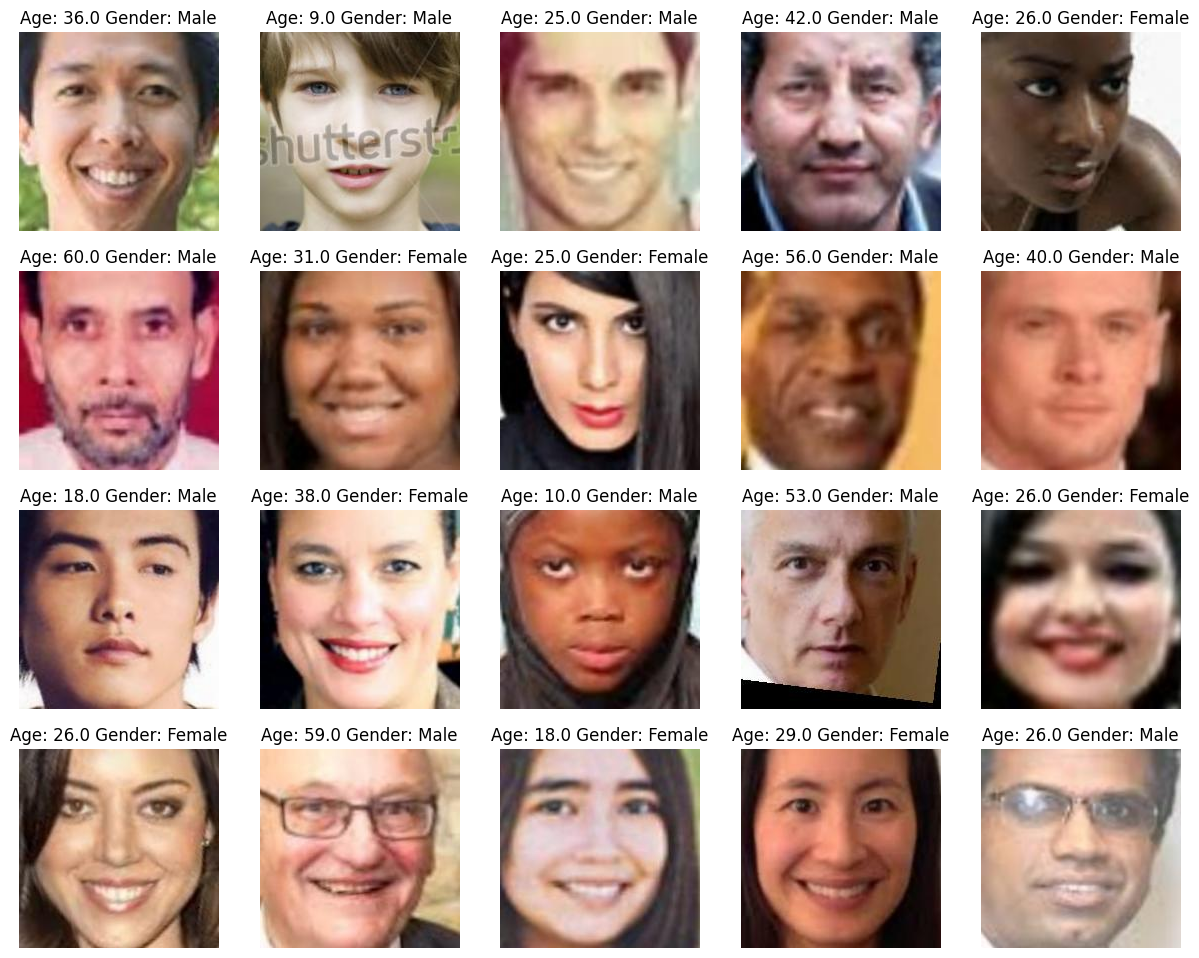

In [19]:
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("/kaggle/input/utkface-new/UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

Since dataset is too large, It is taking a lot of time to train the model so I am splitting the data and only using half of the dataset.
I have already shuffled all the data to ensure no biasness in the dataset.

In [20]:
train, test = train_test_split(df, test_size=0.85, random_state=42)

In [21]:
train.head()

,image,age,gender
18199,26_1_3_20170119193118682.jpg.chip.jpg,26.0,1
19557,1_0_2_20161219194811588.jpg.chip.jpg,1.0,0
20132,40_0_2_20170104171941730.jpg.chip.jpg,40.0,0
11849,35_1_2_20170116233432190.jpg.chip.jpg,35.0,1
2100,26_1_3_20170119193139994.jpg.chip.jpg,26.0,1


# Extracting Features

In [26]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("/kaggle/input/utkface-new/UTKFace/"+file, color_mode = "grayscale")
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

<ipython-input-26-18704963e14e>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((128,128), Image.ANTIALIAS)


In [27]:
x_train.shape

(3556, 128, 128, 1)

# Normalizing data

In [28]:
x_train = x_train/255

In [29]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [30]:
input_size = (128,128,1)

In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(2)
])


model.compile(optimizer='adam', loss='mse')


x_simple = x_train[:100]
y_simple = [y_gender[:100], y_age[:100]]

model.fit(x=x_simple, y=y_simple, epochs=5, callbacks=[callback])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 128, 128, 1), dtype=float32). Expected shape (None, 128), but input has incompatible shape (None, 128, 128, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 128, 128, 1), dtype=float32)
  • training=True
  • mask=None

# Creating model

Using Convolutional Neural Network but with skip connections. Skip connections are used in Residual NN but I have implemented CNN with little Skip connections (shortcut).

In [31]:
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [32]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [33]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 126, 126, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 42, 42, 64)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 40, 40, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 20, 20, 128)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 18, 18, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 9, 9, 256)      │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 20736)          │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │      5,308,672 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      5,308,672 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output (Dense)     │ (None, 1)              │            257 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_output (Dense)        │ (None, 1)              │            129 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,020,546 (42.04 MB)

 Trainable params: 11,020,418 (42.04 MB)

 Non-trainable params: 128 (512.00 B)

# Training the model

In [42]:
pip install --upgrade tensorflow

In [41]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [39]:
import tensorflow as tf

# 创建一个简单的Lambda回调函数来打印每个epoch结束后的logs
callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(f"Epoch: {epoch}, Logs: {logs}")
)

# 训练模型时加入这个回调
try:
    model_history = model.fit(
        x=x_train,
        y=[y_gender, y_age],
        batch_size=10,
        epochs=20,
        validation_split=0.1,
        callbacks=[callback]
    )
except AttributeError as e:
    print(f"Error occurred: {e}")

Epoch 1/20
Error occurred: 'NoneType' object has no attribute 'items'


In [40]:
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)

Epoch 1/20


AttributeError: 'NoneType' object has no attribute 'items'

# Visualizing loss

In [ ]:
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predicting test image

In [ ]:
index=50
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

According to the loss, the model is overfitting. I should have add some more regularization in the model to prevent overfitting but it is taking a lot of time. With 5k images, it takes 2.5 hours to fit on the train set. I stopped here but you can try adding regularization techniques to prevent overfitting.

In [ ]:
index=20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')